## VAE Simple

### [celebA Code]

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from model.vae_conv import VAE
import torch.nn.functional as F
from pytorch_model_summary import summary
import torchvision.datasets as dset
import cv2, math

/home/sha/anaconda3/envs/dvaa/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


make directories

In [2]:
if not os.path.exists(f"weight"):
    os.makedirs(f"weight")
if not os.path.exists(f"content"):
    os.makedirs(f"content")
if not os.path.exists(f"weight/vae_celeba"):
    os.makedirs(f"weight/vae_celeba")
if not os.path.exists(f"content/vae_celeba"):
    os.makedirs(f"content/vae_celeba")

Show Function (input: tensor)

In [3]:
def imshow(img, gray=False, size=2):
    '''
    input: tensor [3, h, w]
    '''
    d_img = img.permute(1,2,0).numpy()
    d_img = (d_img * 255).astype('uint8')
    plt.figure(figsize=(size,size))   
    if gray:
        plt.imshow(d_img, cmap='gray')
    else:
        plt.imshow(d_img)
    plt.axis('off')
    plt.show()

### Training Process

GPU check

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Dataset Loading

In [5]:
batch_size = 256
rsl = 64
dataroot = "data/celeba"

In [6]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize((rsl, rsl)),
                               transforms.ToTensor()
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True)

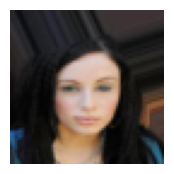

In [7]:
dataiter = iter(dataloader)
images, labels = next(dataiter)
image = images[0]

imshow(image)

In [8]:
print(torch.min(image), torch.max(image))

tensor(0.0039) tensor(0.9137)


Define Model

In [9]:
in_res = rsl
in_cnl = 3
latent_cnl = 8

In [10]:
x = torch.ones([batch_size, in_cnl, in_res, in_res]).to(device)

model = VAE(in_res, in_cnl, latent_cnl).to(device)
model.train()
reconst, mu, log_var = model(x)

print(summary(model,x))
print('input:',x.shape)
print('output:',reconst.shape, mu.shape, log_var.shape)

-----------------------------------------------------------------------------
         Layer (type)           Output Shape         Param #     Tr. Param #
             Conv2d-1      [256, 64, 32, 32]           4,864           4,864
        BatchNorm2d-2      [256, 64, 32, 32]             128             128
               ReLU-3      [256, 64, 32, 32]               0               0
             Conv2d-4     [256, 128, 16, 16]         204,928         204,928
        BatchNorm2d-5     [256, 128, 16, 16]             256             256
               ReLU-6     [256, 128, 16, 16]               0               0
             Conv2d-7       [256, 256, 8, 8]         819,456         819,456
        BatchNorm2d-8       [256, 256, 8, 8]             512             512
               ReLU-9       [256, 256, 8, 8]               0               0
            Conv2d-10       [256, 512, 8, 8]       1,180,160       1,180,160
       BatchNorm2d-11       [256, 512, 8, 8]           1,024           1,02

Training Setting

In [11]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
max_iter = 20000
save_iter = 1000
losses = []

Sampling Setting

In [12]:
width_num = int(math.sqrt(batch_size))
height_num = int(math.sqrt(batch_size))
total_num = width_num * height_num

if total_num > 100:
    width_num = height_num = 10
    total_num = 100

latent_res = in_res // 8
latent_cnl = latent_cnl

print('width_num, height_num, total_num:',width_num, height_num, total_num)
print('latent_res, latent_cnl:', latent_res, latent_cnl)
print('latent_dim:', (latent_res**2)*latent_cnl)

width_num, height_num, total_num: 10 10 100
latent_res, latent_cnl: 8 8
latent_dim: 512


Setting Path

In [13]:
SAVE_PATH = './weight/vae_celeba/conv_vae'
LAST_SAVE_PATH = './weight/vae_celeba/conv_vae.pth'
CONTENT_PATH = './content/vae_celeba/conv_vae'

Training

In [14]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [15]:
print('-------------------------------------------------------------------')
print("Training Start")
print('-------------------------------------------------------------------\n')

running = True
iter = 0
running_loss = 0.0

while(running):
    for data in dataloader:
        input, _ = data
        input = input.to(device)

        # forward
        reconst, mu, log_var = model(input)

        # compute reconstruction loss and KL divergence
        loss = loss_function(reconst, input, mu, log_var)
        running_loss += loss.item()

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check loss per 50 iteration
        if (iter+1) % 50 == 0:
            print(f"[{iter+1}] Loss: {loss.item()}")

        # record iteration
        iter += 1

        # save model per [save_iter] step
        if (iter+1) % save_iter == 0:
            torch.save(model.state_dict(), SAVE_PATH+f'_{iter+1}iter.pth')
            print('<< model save at [%d] iter! >>' % (iter+1))

            '''
            ================
            Save Loss
            ================
            '''
            losses.append(running_loss / save_iter)
            print('-------------------------------------------------------------------')
            print(f"Iteration {iter+1}/{max_iter}, Loss: {running_loss / save_iter}")
            print('-------------------------------------------------------------------')
            running_loss = 0.0 

            '''
            ================
            Save Image
            ================
            '''
            out_img = np.zeros((in_res*height_num, in_res*width_num, 3)) # [in_res*h_num, in_res*w_num, 3]

            with torch.no_grad():
                noise = torch.randn((total_num, latent_cnl, latent_res, latent_res)).to(device) # [t_num, latent_cnl, latent_res, latent_res]
                generated = model.decode(noise) # [t_num, 3, in_res, in_res]

            np_g = generated.permute(0,2,3,1).cpu().detach().numpy()  # [t_num, in_res, in_res, 3]
            rs_img = np.resize(np_g, (height_num, width_num, in_res, in_res, in_cnl)) # [h_num, w_num, in_res, in_res, 3]

            # make numpy images to grid image
            for i in range(height_num):
                for j in range(width_num):
                    out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 0] = rs_img[i, j, :, :, 0]
                    out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 1] = rs_img[i, j, :, :, 1]
                    out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 2] = rs_img[i, j, :, :, 2]

            file_path = CONTENT_PATH + f"_iter_{iter+1}.png"
            save_img = (out_img * 255).astype('uint8')
            save_img = cv2.cvtColor(save_img, cv2.COLOR_BGR2RGB)
            cv2.imwrite(file_path, save_img)

        # training end
        if iter == max_iter:
            running = False
            break

# last epoch -> save last model 
print("Training End")
torch.save(model.state_dict(), LAST_SAVE_PATH)
print("Last Model Saved")

-------------------------------------------------------------------
Training Start
-------------------------------------------------------------------



[50] Loss: 1742913.875
[100] Loss: 1662143.125
[150] Loss: 1659782.5
[200] Loss: 1653875.375
[250] Loss: 1641757.25
[300] Loss: 1646922.625
[350] Loss: 1637363.75
[400] Loss: 1608770.875
[450] Loss: 1625111.5
[500] Loss: 1648174.0
[550] Loss: 1617427.375
[600] Loss: 1639137.875
[650] Loss: 1626023.625
[700] Loss: 1628940.25
[750] Loss: 1652113.375
[800] Loss: 1612070.0
[850] Loss: 1606562.0
[900] Loss: 1638071.875
[950] Loss: 1593784.5
<< model save at [1000] iter! >>
-------------------------------------------------------------------
Iteration 1000/20000, Loss: 1645384.2365
-------------------------------------------------------------------
[1000] Loss: 1610803.875
[1050] Loss: 1630047.75
[1100] Loss: 1623699.875
[1150] Loss: 1606435.75
[1200] Loss: 1619858.625
[1250] Loss: 1622425.5
[1300] Loss: 1634904.375
[1350] Loss: 1605166.125
[1400] Loss: 1603746.125
[1450] Loss: 1616194.25
[1500] Loss: 1627227.875
[1550] Loss: 1609804.75
[1600] Loss: 1636614.625
[1650] Loss: 1620423.75
[1700] 

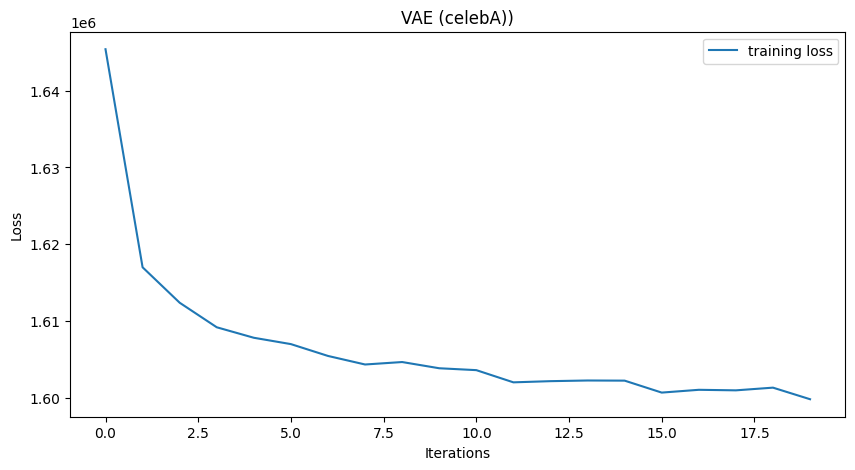

In [16]:
plt.figure(figsize=(10,5))
plt.title("VAE (celebA))")
plt.plot(losses,label="training loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Generating Process

model

In [22]:
in_res = 64
in_cnl = 3
latent_cnl = 8

SAVED_PATH = '/home/sha/medical_system/ldm/weight/vae_celeba/conv_vae_20000iter.pth'
CONTENT_PATH = './content/vae_celeba/conv_vae'

In [23]:
model = VAE(in_res, in_cnl, latent_cnl).to(device)

try:
    model.load_state_dict(torch.load(SAVED_PATH))
    model.eval()
    print('load model ok!')
except:
    print('error')

load model ok!


In [40]:
width_num = 6
height_num = 6
total_num = width_num * height_num

latent_res = in_res // 8
latent_cnl = latent_cnl
latent_dim = (latent_res**2) * latent_cnl

print('width_num, height_num, total_num:',width_num, height_num, total_num)
print('latent_res, latent_cnl:', latent_res, latent_cnl)
print('latent_dim:', (latent_res**2)*latent_cnl)

width_num, height_num, total_num: 6 6 36
latent_res, latent_cnl: 8 8
latent_dim: 512


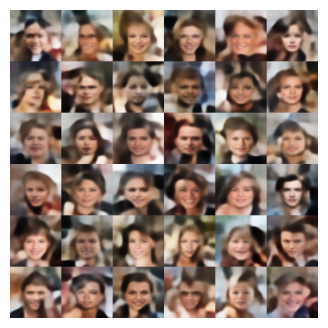

save ok!


In [41]:
out_img = np.zeros((in_res*height_num, in_res*width_num, 3)) 

with torch.no_grad():
    noise = torch.randn((total_num, latent_cnl, latent_res, latent_res)).to(device) # [t_num, latent_cnl, latent_res, latent_res]
    generated = model.decode(noise) 
    generated = generated.reshape(-1, in_cnl, in_res, in_res) 

np_g = generated.permute(0,2,3,1).cpu().detach().numpy()  
rs_img = np.resize(np_g, (height_num, width_num, in_res, in_res, in_cnl)) 

# make numpy images to grid image
for i in range(height_num):
    for j in range(width_num):
        out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 0] = rs_img[i, j, :, :, 0]
        out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 1] = rs_img[i, j, :, :, 1]
        out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 2] = rs_img[i, j, :, :, 2]

# show
show = torch.from_numpy(out_img).permute(2,0,1) 
imshow(show, size=4)

# save
file_path = CONTENT_PATH + f"_sample.png"
save_img = (out_img * 255).astype('uint8')
save_img = cv2.cvtColor(save_img, cv2.COLOR_BGR2RGB)
cv2.imwrite(file_path, save_img)
print('save ok!')

Reconstruction

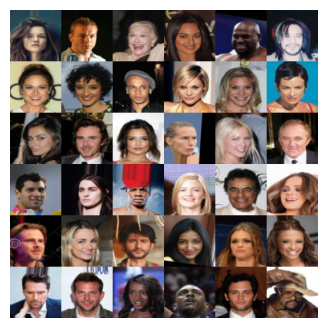

save ok!


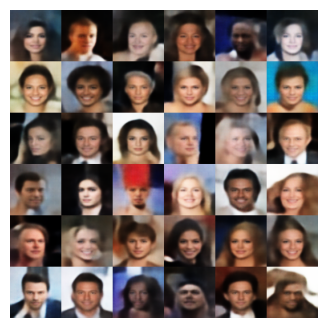

save ok!


In [42]:
with torch.no_grad():
    for iter, data in enumerate(dataloader, 0):
        input, _ = data
        input = input.to(device)
        input = input[:100]

        # forward
        reconst, _, _ = model(input)
        break

    for idx, img in enumerate([input, reconst]):
        out_img = np.zeros((in_res*height_num, in_res*width_num, 3)) 
        np_g = img.permute(0,2,3,1).cpu().detach().numpy()  
        rs_img = np.resize(np_g, (height_num, width_num, in_res, in_res, in_cnl)) 

        # make numpy images to grid image
        for i in range(height_num):
            for j in range(width_num):
                out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 0] = rs_img[i, j, :, :, 0]
                out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 1] = rs_img[i, j, :, :, 1]
                out_img[i * rsl:i * rsl +rsl, j * rsl:j * rsl +rsl, 2] = rs_img[i, j, :, :, 2]

        # show
        show = torch.from_numpy(out_img).permute(2,0,1) 
        imshow(show, size=4)

        # save
        if idx==0:
            file_path = CONTENT_PATH + f"_input.png"
        else:
            file_path = CONTENT_PATH + f"_reconst.png"
        save_img = (out_img * 255).astype('uint8')
        save_img = cv2.cvtColor(save_img, cv2.COLOR_BGR2RGB)
        cv2.imwrite(file_path, save_img)
        print('save ok!')